### Portfolio of Oil Exploration Assets: Learning Options, Sequential Drilling Options and Defer Options 
####  Marco Antonio Guimarães Dias, 
#### Luigi de Magalhães Detomi Calvette
##### RO Congress - Boston 2017


[Paper](http://www.realoptions.org/openconf2017/data/papers/57.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sci
from scipy.stats import norm
import time
import winsound

In [2]:

duration = 1000  # milliseconds
freq = 440  # Hz

In [3]:
#Importar Case 
case=pd.read_csv("Case_Guy_Head.csv", sep=';')
case.set_index('Type', inplace=True)
case=case.astype(float).T
case

Type,Head
CF,0.20
I_w,80.00
q,0.18
B,950.00
Owner,1.00


In [4]:
###Dados de Entrada###
r=0.03
delta=0.038
sigma=0.3
tau=3
P=50
rho=0.5
CF=case.iloc[0,0]
q=case.iloc[2,0]
B=case.iloc[3,0]
Iw=case.iloc[1,0]
Id=B*5.35 + 650

In [5]:
print(P,CF,q,B,Iw,Id)

50 0.2 0.18 950.0 80.0 5732.5


In [6]:
#Importar Case 1 - DogFish
case1=pd.read_csv("Case_Guy_DogFish.csv", sep=';')
case1.set_index('Type', inplace=True)
case1=case1.astype(float).T
case1

Type,DogFish
CF,0.3
I_w,80.0
q,0.2
B,620.0
Owner,0.0


In [7]:
CF1=case1.iloc[0,0]
q1=case1.iloc[2,0]
B1=case1.iloc[3,0]
Iw1=case1.iloc[1,0]
Id1=B1*5.35 + 650
print(P,CF1,q1,B1,Iw1,Id1)

50 0.3 0.2 620.0 80.0 3967.0


In [8]:
def sinal(CF,CF1,rho):
    
    CF_ins=CF -rho*np.sqrt((CF1 - CF1**2)*(CF-CF**2))/(1-CF1)
    CF_s=CF +rho*np.sqrt((CF1 - CF1**2)*(CF-CF**2))/CF1
    
    return CF_ins,CF_s


In [9]:
def vme(CF,q,P,B,delta,Id,Iw,r):
    #VPL=P*case.iloc[2,0]*case.iloc[3,0] - (case.iloc[3,0]*5.35 + 650)*P/50
    VPL=P*q*B*np.exp(-2*delta) - Id*np.exp(-2*r)
    #c=0.047*P+3
    #VPL=P*case.iloc[2,0]*case.iloc[3,0] - (case.iloc[3,0]*c + 650)
    
    vme=CF*VPL - Iw
    #vme=np.maximum(0,vme)
    ### retorna   VME, Valor, Investimento, (valor - FC*Id), Id+Iw
    return vme, CF*VPL, Iw, CF*P*q*B,CF*Id*np.exp(-2*r) +Iw 

In [10]:
vme(CF,q,P,B,delta,Id,Iw,r)

(425.1226754622025,
 505.1226754622025,
 80.0,
 1709.9999999999998,
 1159.7330377543412)

In [11]:
vme(CF1,q1,P,B1,delta,Id1,Iw1,r)

(523.0841727818366, 603.0841727818366, 80.0, 1860.0, 1200.7939714186143)

In [12]:
#####Valor Beta e Valor Crítico####
def vcritico(I,r,div,sigma,tau):
    if tau <=0:
        vcrit=I
        beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/(sigma**2)) - 0.5,2) +((2*r)/(sigma**2)))
    else:
        if div<=0:
            print("Faça um BSM")
        else:
            
            beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/sigma**2) -0.5,2) +((2*r)/(sigma**2)))
            V_perp= I*(beta/(beta-1))
            V_0=np.maximum(I, (r/div)*I)
            ht= -1*((r-div)*tau + 2*sigma*np.sqrt(tau))*(V_0/(V_perp - V_0))
            vcrit= V_0 + (V_perp - V_0)*(1- np.exp(ht))
    return[beta,vcrit, V_perp]
            
        
        

In [13]:
####Método Black Merton e Scholes
def bsm(V,I,r,div,sigma,tau):
    #Opção de Compra Europeia com dividendos - Merton
    

    if tau <=0:
        call=np.maximum(V-I,0)
        put=np.maximum(I-V,0)
    else:
        h1=(np.log(V/I) + ((r-div) +(0.5*np.power(sigma,2)))*tau)/(sigma*np.sqrt(tau))
        h2=h1 -sigma*np.sqrt(tau)
        
        call= V*np.exp(-div*tau)*norm.cdf(h1) -I*np.exp(-r*tau)*norm.cdf(h2)
        put= call + (np.exp(-r*tau)*I - V*np.exp(-div*tau))
        put2= I*np.exp(-r*tau)*(1- norm.cdf(h2)) - V*np.exp(-div*tau)*(1-norm.cdf(h1))
    #return[call, put, norm.cdf(h1), norm.cdf(h2),put2]
    return[call, put]





In [14]:
###Função probabilidade para cálculo do gatilho pelo método de aproximação analítica
def prob(V,tau,gama,h,vcrit,r,div,sigma):
    ####Função probabilidade
    lamba=(-r +(gama*(r-div)) +0.5*gama*(gama-1)*sigma**2)*tau
    dist= -(np.log(V/h)+((r-div)+(gama - 0.5)*sigma**2)*tau)/(sigma*np.sqrt(tau))
    kappa= (2*gama -1) +  2*(r-div)/(sigma**2)
    prob=np.exp(lamba)*(V**gama)*(norm.cdf(dist) - ((vcrit/V)**kappa)*(norm.cdf(dist -(2*np.log(vcrit/V))/(sigma*np.sqrt(tau)))))
    
    return[prob]
    

In [15]:
### Método Bjerksund e Stensland (1993) - saida - Derivativo, Gatilho e V_0
def bjst(V,I,r,div,sigma,tau):
    #### Call americana
    if div <=0: #igual a call europeia
        bs=bsm(V,I,r,div,sigma,tau)[0]
    else:
        beta=vcritico(I,r,div,sigma,tau)[0]
        vcrit=vcritico(I,r,div,sigma,tau)[1]
        alpha= (vcrit - I)*vcrit**(-beta)
        
        if V>= vcrit:
            bs=V-I
        else:
            bs= alpha*V**beta -alpha*prob(V,tau,beta,vcrit,vcrit,r,div,sigma)[0]+prob(V,tau,1,vcrit,vcrit,r,div,sigma)[0]-prob(V,tau,1,I,vcrit,r,div,sigma)[0]-I*prob(V,tau,0,vcrit,vcrit,r,div,sigma)[0]+I*prob(V,tau,0,I,vcrit,r,div,sigma)[0]
    
    return[bs, vcrit, V]
    
    

In [16]:
##################################################3
#####################################################
###########Solucao e_ DF ##############


In [17]:
def diffinexpcart(P,I,r,div,sigma,tau,accur):
    #############################################################
    #######Método por diferenças finitas explícitas##############
    #accur=0.05  #Porcentagem de acurácia
    
    #####Solução por diferenças finita explícitas###
    #Precisão em e intervalo da célula em V
    deltaP=P*accur
    
    # M são as divisões do grid em V
    #Perpetuidade vcritico não esta na programacao
    #M= int(1.1*vcritico(I,r,div,sigma,tau)[2]/deltaV) # Max é 10% acima do gatilho em perpetuidade. Vcrit- com gati precisa de tau
    M=int(2*vcritico(I,r,div,sigma,tau)[2]/deltaP)
    #M=int(3*P/deltaP)
    #PGrid=int(P/deltaP) #Ponto do grid onde esta P_0. 
    #deltat= (deltaP**2)/((sigma**2)*((3*I)**2)) #Convergência: Critério do peso central >=0. Pmax=3I ><1.1Gatilho_perp
    deltat= (deltaP**2)/((sigma**2)*((3*I)**2))
    N= int(tau/deltat) +1
    
    df=1/(1+(r*deltat)) # fator de desconto
    
    
    #Vetor Pt
    Pt=np.zeros(M+1)
    Gatilho=np.zeros((N+1))
    F=np.zeros((N+1,M+1))
    deltat=tau/N
    for i in range(M+1):
        Pt[i]= i*deltaP
        F[N,i]=np.maximum(Pt[i]-I,0) 
    Gatilho[N]=I
        #Gatilho[N]=I
    
    
    #print(PGrid,Pt.shape)
    PGrid=np.where(np.round(Pt,2)==np.round(P,2))[0][0]
    ##############Loop################
    for j in range(N-1,-1,-1): #de N-1 até zero(-1) pulando em -1
        for i in range(1,M,1): # de 1 até M-1 pulando em 1
            pu= 0.5*((sigma**2)*(i**2) + ((r - div)*i))*deltat
            pm = 1 - (sigma**2)*(i**2)*deltat
            pdown = 0.5*((sigma**2)*(i**2) - ((r - div)*i))*deltat
            F[j,i]= df*(pu*F[j+1,i+1] + pm*F[j+1,i] + pdown*F[j+1,i - 1])
            
            ###Vetor Gatilho####
            if F[j,i]<Pt[i]-I  and F[j,i-1]>Pt[i-1]-I :
                Gatilho[j]=(Pt[i-1] +Pt[i])*.5
            F[j,i]=np.maximum(Pt[i]-I,F[j,i])
            
           
        
        F[j,0]=0
        F[j,M]=Pt[i]-I
        
    T=np.linspace(0,tau,num=N+1)
    return[F[0,PGrid],PGrid,F,T,Pt,Gatilho]



In [18]:
accur=0.005

In [19]:

V_cf=CF*P*q*B*np.exp(-2*delta)
Id_cf=CF*Id*np.exp(-2*r)


In [20]:
start=time.time()
opcao,PGrid,mapa,tempo,preco,gatilho=diffinexpcart(V_cf,Id_cf+Iw,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)

winsound.Beep(freq, duration)


minutos- 5.098897727330526


In [21]:
V_cf, preco[PGrid]

(1584.8557132165433, 1584.8557132165433)

In [22]:
preco=preco/(CF*q*B*np.exp(-2*delta))

In [23]:
g=gatilho/(CF*q*B*np.exp(-2*delta))

gatilho é: 73.125
opcao vale: 497.7179544810564


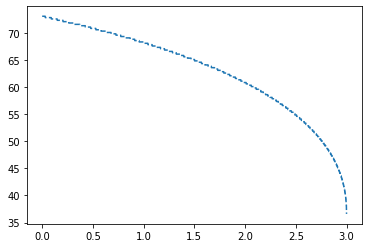

In [24]:
print('gatilho é:',gatilho[0]/(CF*q*B*np.exp(-2*delta)))
print('opcao vale:', opcao)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo,g, ls='--')


(-5, 80)

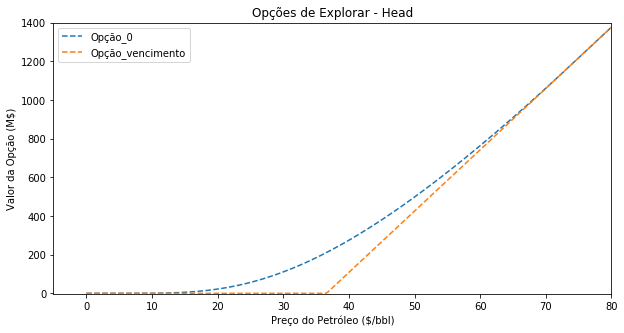

In [25]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(preco,mapa[0,:], ls='--')

#ax.plot(preco,venc, ls='--')
ax.plot(preco,mapa[-1,:], ls='--')

plt.legend(['Opção_0','Opção_vencimento'])
ax.set_title('Opções de Explorar - Head')
ax.set_ylabel('Valor da Opção (M\$)')
ax.set_xlabel('Preço do Petróleo (\$/bbl)')

ax.set_ylim(-5,1400)
ax.set_xlim(-5,80)



In [26]:
sinal(CF,CF1,rho)

(0.06906926585840459, 0.5055050463303894)

In [27]:

V_inv=P*q*B*np.exp(-2*delta)
Id_inv=Id*np.exp(-2*r)


In [28]:
start=time.time()
opcao_inv,PGrid_inv,mapa_inv,tempo_inv,preco_inv,gatilho_inv=diffinexpcart(V_inv,Id_inv,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 3.836642615000407


In [29]:
V_inv, preco_inv[PGrid_inv]

(7924.2785660827185, 7924.2785660827185)

In [30]:
preco_inv=preco_inv/(q*B*np.exp(-2*delta))

In [31]:
g_inv=gatilho_inv/(q*B*np.exp(-2*delta))

gatilho é: 68.125
opcao vale: 2755.6695849420903


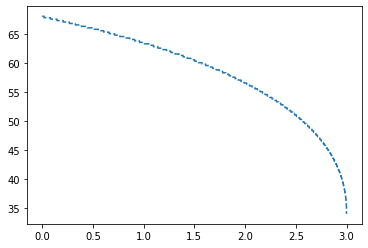

In [32]:
print('gatilho é:',g_inv[0])
print('opcao vale:', opcao_inv)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo_inv,g_inv, ls='--')


In [33]:
len(preco)

785

In [34]:
valor_vme=[]
for i in range(len(preco)):
    valor_vme.append(vme(CF,q,preco[i],B,delta,Id,Iw,r)[0])
#print(valor_vme)

Text(0.5, 0, 'Preço do Petróleo (\\$/bbl)')

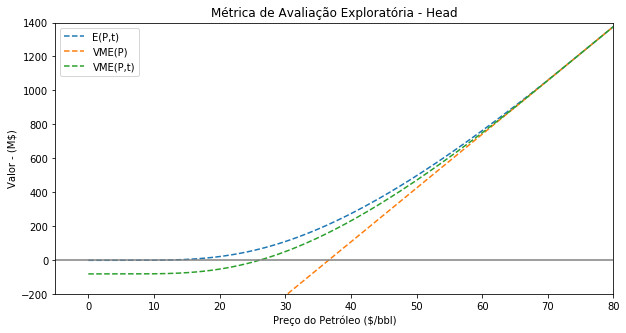

In [35]:
fig,ax=plt.subplots(figsize=(10,5))

ax.plot(preco,mapa[0,:], ls='--')
ax.plot(preco,valor_vme, ls='--')
ax.plot(preco_inv,CF*mapa_inv[0,:] - Iw, ls='--')

ax.axhline(0, linestyle='-', color='grey')



#ax.plot(preco,venc, ls='--')
#ax.plot(preco_inv/(0.1*300*np.exp(-2*delta)),mapa_inv[-1,:], ls='--')

plt.legend(['E(P,t)','VME(P)', 'VME(P,t)'])
ax.set_ylim(-200,1400)
ax.set_xlim(-5,80)
ax.set_title('Métrica de Avaliação Exploratória - Head')

ax.set_ylabel('Valor - (M\$)')
ax.set_xlabel('Preço do Petróleo (\$/bbl)')



In [36]:
winsound.Beep(freq,duration)


In [37]:
VME=CF*opcao_inv -Iw
print(VME)
print(g_inv[0])

471.13391698841804
68.125


In [38]:
if P>g[0]:
    custo=VME*(1-np.exp(-r/12))
else:
    custo=0

In [39]:
################Calculo do VME(P,t) do GoldFish############### Necessario pois ele ser o custo da nao perfuracao

In [40]:

V_inv1=P*q1*B1*np.exp(-2*delta)
Id_inv1=Id1*np.exp(-2*r)


In [41]:
start=time.time()
opcao_inv1,PGrid_inv1,mapa_inv1,tempo_inv1,preco_inv1,gatilho_inv1=diffinexpcart(V_inv1,Id_inv1,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 3.2968588789304096


In [42]:
V_inv1, preco_inv1[PGrid_inv1]

(5746.26048066817, 5746.26048066817)

In [43]:
preco_inv1=preco_inv1/(q1*B1*np.exp(-2*delta))

In [44]:
g_inv1=gatilho_inv1/(q1*B1*np.exp(-2*delta))

gatilho de investir em Dog é: 64.875
opcao de investir em Dog vale: 2127.446940079004


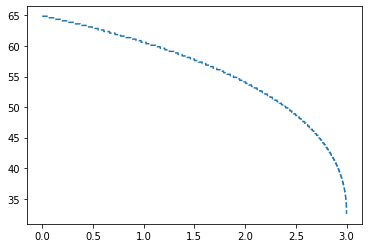

In [45]:
print('gatilho de investir em Dog é:',g_inv1[0])
print('opcao de investir em Dog vale:', opcao_inv1)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo_inv1,g_inv1, ls='--')


In [46]:
#valor_vme1=[]
#for i in range(len(preco_inv1)):
#    valor_vme1.append(vme(CF1,q1,preco1[i],B1,delta,Id1,Iw1,r)[0])
#print(valor_vme)

In [47]:
#############VME(P,t) do DogFish será o custo da espera do portfolio DogFish+Feather 
VME_custo=CF1*opcao_inv1 -Iw1
print(VME)
print(g_inv1[0])

471.13391698841804
64.875


Text(0.5, 0, 'Preço do Petróleo (\\$/bbl)')

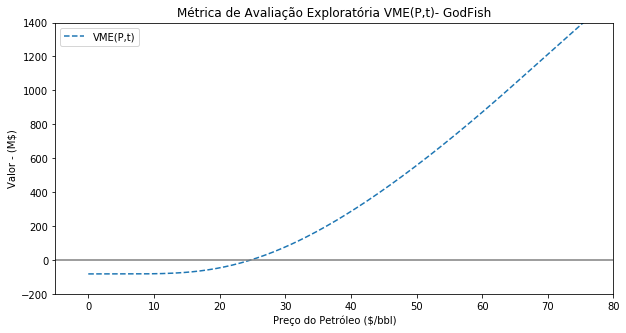

In [48]:
fig,ax=plt.subplots(figsize=(10,5))

#ax.plot(preco_inv1,valor_vme1, ls='--')
ax.plot(preco_inv1,CF1*mapa_inv1[0,:] - Iw1, ls='--')

ax.axhline(0, linestyle='-', color='grey')



#ax.plot(preco,venc, ls='--')
#ax.plot(preco_inv/(0.1*300*np.exp(-2*delta)),mapa_inv[-1,:], ls='--')

plt.legend(['VME(P,t)'])
ax.set_ylim(-200,1400)
ax.set_xlim(-5,80)
ax.set_title('Métrica de Avaliação Exploratória VME(P,t)- GodFish')

ax.set_ylabel('Valor - (M\$)')
ax.set_xlabel('Preço do Petróleo (\$/bbl)')



In [49]:
######################################################
####Importar opcoa de explorar - E(P,t) -  do portfolio DogFish + Feather###
#################################Interpolar para preco_inv#####

In [50]:
opcao_port=np.loadtxt('Port_Explorar_opcao_dog_feather.txt')
preco_port=np.loadtxt('Port_Explorar_preco_dog_feather.txt')

In [51]:
opcao_port_interp=np.interp(preco_inv,preco_port,opcao_port)


In [52]:
######################################################
####Importar VME(P,t) do portfolio DogFish + Feather###
#################################Interpolar para preco_inv#####

In [53]:
vme_opcao_port=np.loadtxt('Port_VME_opcao_dog_feather.txt')
vme_preco_port=np.loadtxt('Port_VME_preco_dog_feather.txt')

In [54]:
vme_port_interp=np.interp(preco_inv,vme_preco_port,vme_opcao_port)


Text(0.5, 0, 'Preço do Petróleo (\\$/bbl)')

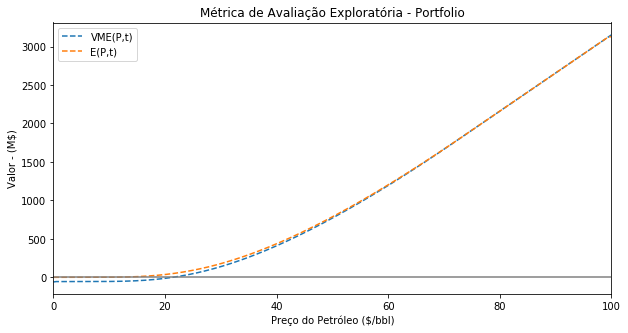

In [55]:
fig,ax=plt.subplots(figsize=(10,5))

ax.plot(preco_inv,vme_port_interp, ls='--')
ax.plot(preco_inv,opcao_port_interp, ls='--')
ax.axhline(0, linestyle='-', color='grey')



#ax.plot(preco,venc, ls='--')
#ax.plot(preco_inv/(0.1*300*np.exp(-2*delta)),mapa_inv[-1,:], ls='--')

plt.legend([ 'VME(P,t)','E(P,t)'])
#ax.set_ylim(-200,1400)
ax.set_xlim(0,100)
ax.set_title('Métrica de Avaliação Exploratória - Portfolio')

ax.set_ylabel('Valor - (M\$)')
ax.set_xlabel('Preço do Petróleo (\$/bbl)')



In [56]:
###Gatilho VME(P,t)=Opcao
gatilho_port=preco_inv[opcao_port_interp-vme_port_interp<0.0001][0]
print(gatilho_port)

73.0


In [57]:
if P>gatilho_port:  # gatilho do portfólio DogFish + Feather - não é o gatilgo do dogFish
    custo1=VME_custo*(1-np.exp(-r/12))
else:
    custo1=0

In [58]:
###########3Informação para o portfolio DogFish + Feather - vinda do Head###############

In [59]:
opcao_port_pos=np.loadtxt('Port_Explorar_pos_opcao_dog_feather.txt')
preco_port_pos=np.loadtxt('Port_Explorar_pos_preco_dog_feather.txt')

In [60]:
opcao_port_pos_interp=np.interp(preco_inv,preco_port_pos,opcao_port_pos)


In [61]:
opcao_port_neg=np.loadtxt('Port_Explorar_neg_opcao_dog_feather.txt')
preco_port_neg=np.loadtxt('Port_Explorar_neg_preco_dog_feather.txt')

In [62]:
opcao_port_neg_interp=np.interp(preco_inv,preco_port_neg,opcao_port_neg)


In [63]:
###Criar a esperaca da informação - Porfólio DogFish+ Feather ponderado pela chance do evento Head

In [64]:
F_zero1=CF*opcao_port_pos_interp+ (1-CF)*opcao_port_neg_interp


In [65]:
###Renomear para ficar igual ao Algo 3 e 4

L_zero1=vme_port_interp
#Exp_zero1=opcao_port_pos_interp
Exp_zero1=opcao_port_interp

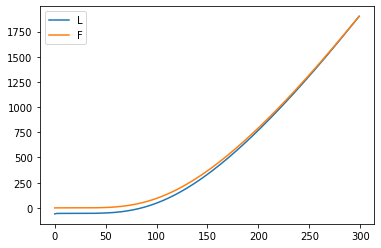

In [66]:
plt.plot(L_zero1[0:300])
plt.plot(F_zero1[0:300])

plt.legend(['L','F'])

In [67]:
F_zero1-L_zero1>0.1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [68]:
###################Informação para o Head#########################

In [69]:
start=time.time()

opcao_up,PGrid_up,mapa_up,tempo_up,preco_up,gatilho_up=diffinexpcart(sinal(CF,CF1,rho)[1]*P*q*B*np.exp(-2*delta),sinal(CF,CF1,rho)[1]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_down,PGrid_down,mapa_down,tempo_down,preco_down,gatilho_down=diffinexpcart(sinal(CF,CF1,rho)[0]*P*q*B*np.exp(-2*delta),sinal(CF,CF1,rho)[0]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_info=CF1*opcao_up + (1-CF1)*opcao_down

cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 10.99769549369812


In [70]:
preco_up=preco_up/(sinal(CF,CF1,rho)[1]*q*B*np.exp(-2*delta))
preco_down=preco_down/(sinal(CF,CF1,rho)[0]*q*B*np.exp(-2*delta))

In [71]:
F_up_zero=np.interp(preco_inv,preco_up,mapa_up[0,:])
F_down_zero=np.interp(preco_inv,preco_down,mapa_down[0,:])
F_zero=CF1*F_up_zero+ (1-CF1)*F_down_zero

Exp_zero=np.interp(preco_inv,preco,mapa[0,:])

L_zero=CF*mapa_inv[0,:] - Iw


In [72]:
###Verificar o tamanho para o jogo####
len(L_zero1), len(L_zero), len(F_zero), len(F_zero1), len(Exp_zero), len(Exp_zero1)

(731, 731, 731, 731, 731, 731)

In [73]:
pa=preco_inv[F_zero-L_zero<0.01][0]
pa1=preco_inv[F_zero1-L_zero1<0.01][0]
print(pa)
print(pa1)

82.25
78.5


Hoje, o gatilho explorar $\Pi$ Dog+Feather é: 73.0
Hoje, o gatilho explorar Head é: 73.125
Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é: 78.5
Hoje, o gatilho simultaneo Head é: 82.25


[]

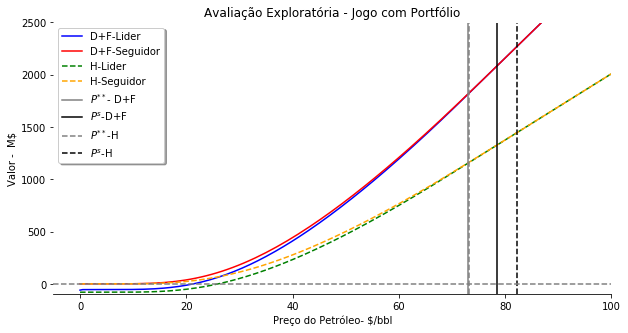

In [74]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)
print('Hoje, o gatilho explorar $\Pi$ Dog+Feather é:',round(gatilho_port,3))
print('Hoje, o gatilho explorar Head é:',round(g[0],3))
print('Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é:',pa1)
print('Hoje, o gatilho simultaneo Head é:',pa)

ax.plot(preco_inv,L_zero1, color='blue', ls='-' )
ax.plot(preco_inv,F_zero1, color='red', ls='-' )

ax.plot(preco_inv,L_zero, color='green', ls='--' )
ax.plot(preco_inv,F_zero, color='orange', ls='--' )

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axvline(x=gatilho_port, linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')


ax.axhline(0, linestyle='--', color='grey')

#ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['D+F-Lider','D+F-Seguidor','H-Lider','H-Seguidor','$P^{**}$- D+F','$P^{s}$-D+F','$P^{**}$-H','$P^{s}$-H'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo- $/bbl')
ax.set_ylabel('Valor -  M$')
ax.set_title('Avaliação Exploratória - Jogo com Portfólio')

ax.set_xlim(right=100)
ax.set_ylim(top=2500)
ax.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [75]:
np.where(preco_inv>100)[0][0]

401

In [76]:
preco_inv[100]

25.0

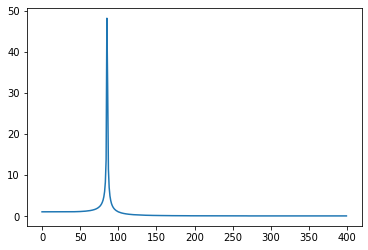

In [77]:
plt.plot(np.round(np.absolute(np.round(F_zero1,2)/np.round(L_zero1,2) -1),2)[0:400])

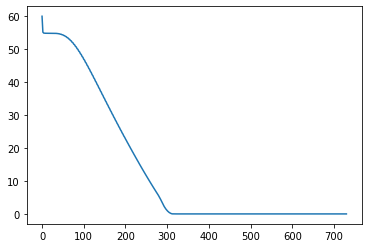

In [78]:
plt.plot(F_zero1- L_zero1)
#plt.plot(np.absolute(F_zero-L_zero)[0:400])

Hoje, o gatilho explorar $\Pi$ Dog+Feather é: 73.0
Hoje, o gatilho explorar Head é: 73.125
Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é: 78.5
Hoje, o gatilho simultaneo Head é: 82.25


[]

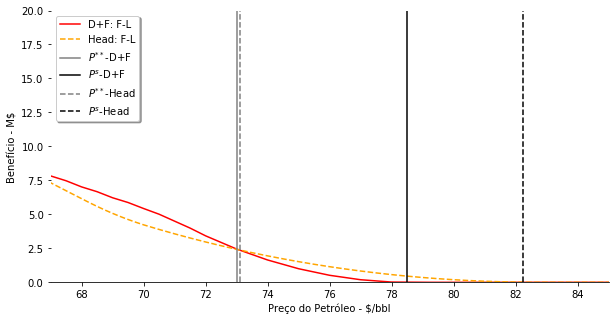

In [79]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)
print('Hoje, o gatilho explorar $\Pi$ Dog+Feather é:',round(gatilho_port,3))
print('Hoje, o gatilho explorar Head é:',round(g[0],3))
print('Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é:',pa1)
print('Hoje, o gatilho simultaneo Head é:',pa)

ax.plot(preco_inv,F_zero1-L_zero1, color='red', ls='-' )

ax.plot(preco_inv,F_zero-L_zero, color='orange', ls='--' )

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axvline(x=gatilho_port, linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')


#ax.axhline(0, linestyle='--', color='grey')

#ax.axvline(pa, linestyle='--', color='grey')

#ax.set_ylim(0,100)
#ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['D+F: F-L','Head: F-L','$P^{**}$-D+F','$P^s$-D+F','$P^{**}$-Head','$P^s$-Head'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo - $/bbl')
ax.set_ylabel('Benefício - M\$')
ax.set_xlim(right=85)
ax.set_xlim(left=0)
ax.set_xlim(left=67)
ax.set_ylim(top=20)
#ax.set_ylim(top=80)
ax.set_ylim(bottom=0)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

Hoje, o gatilho explorar $\Pi$ Dog+Feather é: 73.0
Hoje, o gatilho explorar Head é: 73.125
Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é: 78.5
Hoje, o gatilho simultaneo Head é: 82.25


[]

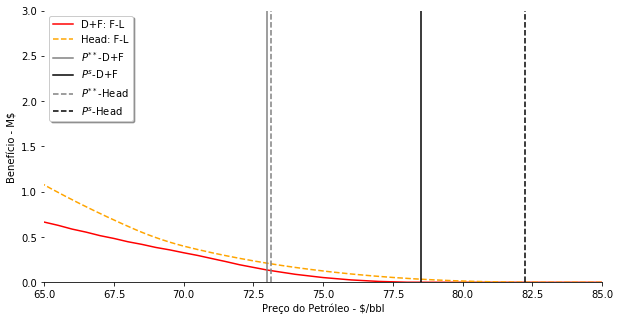

In [80]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)
print('Hoje, o gatilho explorar $\Pi$ Dog+Feather é:',round(gatilho_port,3))
print('Hoje, o gatilho explorar Head é:',round(g[0],3))
print('Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é:',pa1)
print('Hoje, o gatilho simultaneo Head é:',pa)

ax.plot(preco_inv,(F_zero1/L_zero1 -1)*100, color='red', ls='-' )

ax.plot(preco_inv,(F_zero/L_zero -1)*100, color='orange', ls='--' )

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axvline(x=gatilho_port, linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')


#ax.axhline(0, linestyle='--', color='grey')

#ax.axvline(pa, linestyle='--', color='grey')

#ax.set_ylim(0,100)
#ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['D+F: F-L','Head: F-L','$P^{**}$-D+F','$P^s$-D+F','$P^{**}$-Head','$P^s$-Head'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo - $/bbl')
ax.set_ylabel('Benefício - M\$')
ax.set_xlim(right=85)
ax.set_xlim(left=65)
ax.set_ylim(top=3)
ax.set_ylim(bottom=0)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

Hoje, o gatilho explorar $\Pi$ Dog+Feather é: 73.0
Hoje, o gatilho explorar Head é: 73.125
Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é: 78.5
Hoje, o gatilho simultaneo Head é: 82.25


[]

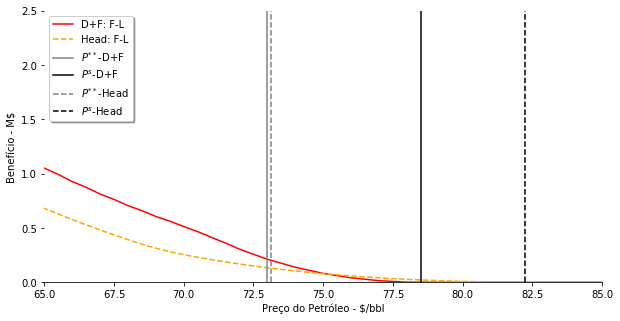

In [81]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)
print('Hoje, o gatilho explorar $\Pi$ Dog+Feather é:',round(gatilho_port,3))
print('Hoje, o gatilho explorar Head é:',round(g[0],3))
print('Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é:',pa1)
print('Hoje, o gatilho simultaneo Head é:',pa)

ax.plot(preco_inv,((F_zero1-L_zero1)/L_zero)*100, color='red', ls='-' )

ax.plot(preco_inv,((F_zero-L_zero)/L_zero1)*100, color='orange', ls='--' )

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axvline(x=gatilho_port, linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')


#ax.axhline(0, linestyle='--', color='grey')

#ax.axvline(pa, linestyle='--', color='grey')

#ax.set_ylim(0,100)
#ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['D+F: F-L','Head: F-L','$P^{**}$-D+F','$P^s$-D+F','$P^{**}$-Head','$P^s$-Head'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo - $/bbl')
ax.set_ylabel('Benefício - M\$')
ax.set_xlim(right=85)
ax.set_xlim(left=65)
ax.set_ylim(top=2.5)
ax.set_ylim(bottom=0)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [82]:
###################################Simulações da Guerra de Atrito##############################################

In [83]:
import nashpy as nash

In [93]:
P1=75
loc=np.where(np.round(preco_inv,2)==P1)[0][0]

In [94]:
###Jogador 1 está na horizontal - DogFish + Feather
VME1=L_zero1[loc]
opcao_info1=F_zero1[loc]
opcao1=Exp_zero1[loc]



In [95]:
if P1>gatilho_port:
    custo1=VME_custo*(1-np.exp(-r/12))
else:
    custo1=0

In [96]:
###Jogador 2 está na Vertical - Head
VME2=L_zero[loc]
opcao_info2=F_zero[loc]
opcao2=Exp_zero[loc]



In [97]:
if P1>g[0]:
    custo2=VME2*(1-np.exp(-r/12))
else:
    custo2=0
    


In [98]:
custo1, custo2

(1.3938421763794093, 3.040074653487324)

In [99]:
####Ações do Jogador 1
A_matrix=[[VME1, VME1],[opcao_info1,opcao1-custo1]]
A_matrix=np.round(A_matrix,2)

In [100]:
###Ações do Jogador 2
B_matrix=[[VME2,opcao_info2],[VME2,opcao2-custo2]]
B_matrix=np.round(B_matrix,2)
war_att=nash.Game(A_matrix,B_matrix)
war_att



Bi matrix game with payoff matrices:

Row player:
[[1912.8  1912.8 ]
 [1913.8  1911.41]]

Column player:
[[1217.55 1219.07]
 [1217.55 1214.51]]

In [107]:
eq=list(war_att.support_enumeration())
#eq=list(war_att.lemke_howson_enumeration())
eq

[(array([1., 0.]), array([0., 1.])),
 (array([0., 1.]), array([1., 0.])),
 (array([0.66666667, 0.33333333]), array([0.58158996, 0.41841004]))]

In [108]:
suporte=[[1,2],[3,4]]
for s1,s2 in eq:
    row_util=np.dot(np.dot(s1,A_matrix),s2)
    quadrante=np.dot(np.dot(s1,suporte),s2)
    col_util=np.dot(np.dot(s1,B_matrix),s2)
    print(quadrante,row_util,col_util)

2.0 1912.8 1219.07
3.0 1913.8 1217.55
2.085076708507693 1912.8 1217.55


In [336]:
len(eq[0])

2

In [222]:
suporte=[[1,2],[3,4]]

In [223]:
####Mapeamendo dos diversos jogos####

In [224]:

matrix=np.zeros((len(preco_inv),6))
for loc in range(len(preco_inv)):    
    #P1=50
    #loc=np.where(np.round(preco_inv,2)==P1)[0][0]
    #print(preco_inv[loc])
    
    VME1=L_zero1[loc]
    opcao_info1=F_zero1[loc]
    opcao1=Exp_zero1[loc]
    
    if preco_inv[loc]>gatilho_port:   #g1[0]
        custo1=VME_custo*(1-np.exp(-r/12)) #VME1
    else:
        custo1=0
        
    ###Jogador 1 está na horizontal - Head
    VME2=L_zero[loc]
    opcao_info2=F_zero[loc]
    opcao2=Exp_zero[loc]

    if preco_inv[loc]>g[0]:
        custo2=VME2*(1-np.exp(-r/12))
    else:
        custo2=0
        

    #Ações do jogador 1
    A_matrix=[[VME1, VME1],[opcao_info1,opcao1-custo1]]
    A_matrix=np.round(A_matrix,2)
    
    ###Ações do Jogador 2
    #A_matrix=[[VME2,VME2],[opcao_info2,opcao2-custo2]]
    #A_matrix=np.round(A_matrix,2)
    


    ###Ações do Jogador 2
    B_matrix=[[VME2,opcao_info2],[VME2,opcao2-custo2]]
    B_matrix=np.round(B_matrix,2)
    war_att=nash.Game(A_matrix,B_matrix)

    eq=list(war_att.support_enumeration())
    #print(eq)


    suporte=[[1,2],[3,4]]
    
    matrix[loc,0]=preco_inv[loc]
    i=1
    for s1,s2 in eq:
        quadrante=np.dot(np.dot(s1,suporte),s2)
        #print(i)
        matrix[loc,i]=quadrante
        i=i+1
        

C:\Users\LG\Anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:196: RuntimeWarning: 
An even number of (2) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


In [225]:
df=pd.DataFrame(matrix)

In [226]:
df.head()

,0,1,2,3,4,5
0,0.00,4.0,0.0,0.0,0.0,0.0
1,0.25,4.0,0.0,0.0,0.0,0.0
2,0.50,4.0,0.0,0.0,0.0,0.0
3,0.75,4.0,0.0,0.0,0.0,0.0
4,1.00,4.0,0.0,0.0,0.0,0.0


In [227]:
df=df.set_index(0)

In [228]:
df[df==0]=np.nan

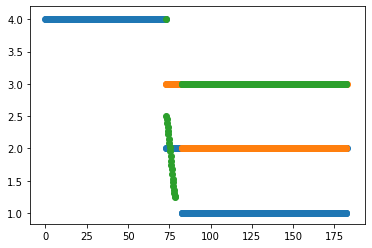

In [229]:
plt.scatter(df.index, df.iloc[:,0])
plt.scatter(df.index, df.iloc[:,1])
plt.scatter(df.index, df.iloc[:,2])
plt.scatter(df.index, df.iloc[:,3])
plt.scatter(df.index, df.iloc[:,4])


In [230]:
df

,1,2,3,4,5
0,,,,,
0.00,4.0,NaN,NaN,NaN,NaN
0.25,4.0,NaN,NaN,NaN,NaN
0.50,4.0,NaN,NaN,NaN,NaN
0.75,4.0,NaN,NaN,NaN,NaN
1.00,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
181.50,1.0,2.0,3.0,NaN,NaN
181.75,1.0,2.0,3.0,NaN,NaN
182.00,1.0,2.0,3.0,NaN,NaN


[]

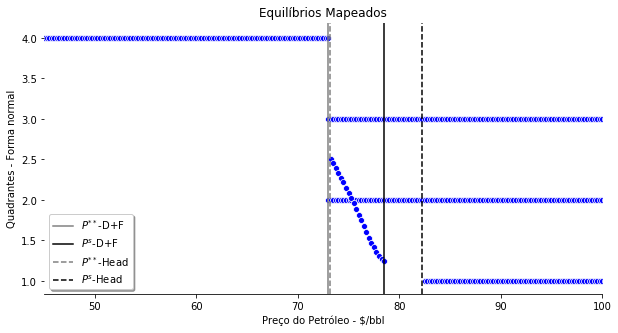

In [338]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')
ax.axvline(x=gatilho_port, linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')

sns.scatterplot(df.index, df.iloc[:,0], color='blue')
sns.scatterplot(df.index, df.iloc[:,1], color='blue')
sns.scatterplot(df.index, df.iloc[:,2], color='blue')
sns.scatterplot(df.index, df.iloc[:,3], color='blue')
sns.scatterplot(df.index, df.iloc[:,4], color='blue')



#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['$P^{**}$-D+F','$P^s$-D+F','$P^{**}$-Head','$P^s$-Head'], loc='lower left', shadow=True)
ax.set_xlabel('Preço do Petróleo - $/bbl')
ax.set_ylabel('Quadrantes - Forma normal')
ax.set_xlim(45,100)

ax.set_title('Equilíbrios Mapeados')

plt.plot()

In [90]:
#################Barganha!###################

In [356]:
preco_barganha=np.loadtxt('barganha_tres_ativos_preco.txt')

In [357]:
vme_barganha=np.loadtxt('barganha_tres_ativos_vme.txt')

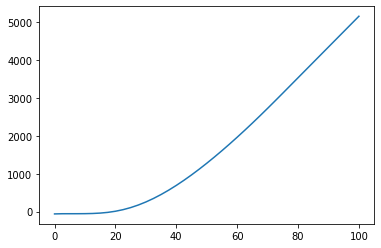

In [358]:
plt.plot(preco_barganha, vme_barganha)

In [359]:
vme_barganha_interp=np.interp(preco_inv,preco_barganha,vme_barganha)

In [362]:
vme_barganha_max=np.maximum(0,vme_barganha_interp)

In [361]:
#Ui=np.maximum(0,L_zero+F_zero1)

In [359]:
#Uj=np.maximum(0,L_zero1+F_zero)

In [363]:
####Pedaco do Godfish
wi=.5+( np.maximum(0,L_zero)-np.maximum(0,L_zero1))/(2*vme_barganha_max)

C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [364]:
wi=np.nan_to_num(wi)

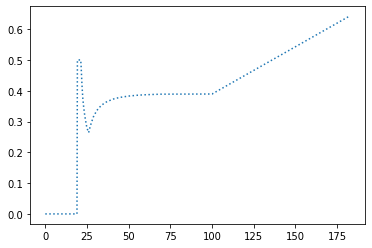

In [365]:
plt.plot(preco_inv,wi, ls=':')

[]

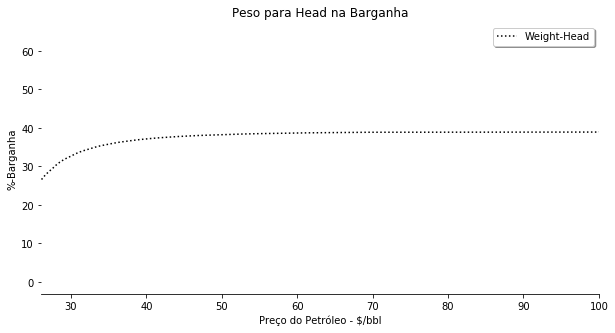

In [399]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

#ax.axvline(pa, linestyle='--', color='grey')
ax.plot(preco_inv,100*wi, ls=':', color='black')
#ax.set_ylim(0,100)
#ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Weight-Head'], shadow=True)
ax.set_xlabel('Preço do Petróleo - $/bbl')
ax.set_ylabel('%-Barganha')
ax.set_xlim(right=100)
ax.set_xlim(left=26)
#ax.set_ylim(top=65)
#ax.set_ylim(bottom=40)
ax.set_title('Peso para Head na Barganha')

plt.plot()

In [368]:
preco_inv[vme_barganha_max>0]

array([ 19.25,  19.5 ,  19.75,  20.  ,  20.25,  20.5 ,  20.75,  21.  ,
        21.25,  21.5 ,  21.75,  22.  ,  22.25,  22.5 ,  22.75,  23.  ,
        23.25,  23.5 ,  23.75,  24.  ,  24.25,  24.5 ,  24.75,  25.  ,
        25.25,  25.5 ,  25.75,  26.  ,  26.25,  26.5 ,  26.75,  27.  ,
        27.25,  27.5 ,  27.75,  28.  ,  28.25,  28.5 ,  28.75,  29.  ,
        29.25,  29.5 ,  29.75,  30.  ,  30.25,  30.5 ,  30.75,  31.  ,
        31.25,  31.5 ,  31.75,  32.  ,  32.25,  32.5 ,  32.75,  33.  ,
        33.25,  33.5 ,  33.75,  34.  ,  34.25,  34.5 ,  34.75,  35.  ,
        35.25,  35.5 ,  35.75,  36.  ,  36.25,  36.5 ,  36.75,  37.  ,
        37.25,  37.5 ,  37.75,  38.  ,  38.25,  38.5 ,  38.75,  39.  ,
        39.25,  39.5 ,  39.75,  40.  ,  40.25,  40.5 ,  40.75,  41.  ,
        41.25,  41.5 ,  41.75,  42.  ,  42.25,  42.5 ,  42.75,  43.  ,
        43.25,  43.5 ,  43.75,  44.  ,  44.25,  44.5 ,  44.75,  45.  ,
        45.25,  45.5 ,  45.75,  46.  ,  46.25,  46.5 ,  46.75,  47.  ,
      

In [369]:
np.max(wi)

0.6419292714531732

In [387]:
wi

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [371]:
preco_inv[wi>0]

array([ 19.25,  19.5 ,  19.75,  20.  ,  20.25,  20.5 ,  20.75,  21.  ,
        21.25,  21.5 ,  21.75,  22.  ,  22.25,  22.5 ,  22.75,  23.  ,
        23.25,  23.5 ,  23.75,  24.  ,  24.25,  24.5 ,  24.75,  25.  ,
        25.25,  25.5 ,  25.75,  26.  ,  26.25,  26.5 ,  26.75,  27.  ,
        27.25,  27.5 ,  27.75,  28.  ,  28.25,  28.5 ,  28.75,  29.  ,
        29.25,  29.5 ,  29.75,  30.  ,  30.25,  30.5 ,  30.75,  31.  ,
        31.25,  31.5 ,  31.75,  32.  ,  32.25,  32.5 ,  32.75,  33.  ,
        33.25,  33.5 ,  33.75,  34.  ,  34.25,  34.5 ,  34.75,  35.  ,
        35.25,  35.5 ,  35.75,  36.  ,  36.25,  36.5 ,  36.75,  37.  ,
        37.25,  37.5 ,  37.75,  38.  ,  38.25,  38.5 ,  38.75,  39.  ,
        39.25,  39.5 ,  39.75,  40.  ,  40.25,  40.5 ,  40.75,  41.  ,
        41.25,  41.5 ,  41.75,  42.  ,  42.25,  42.5 ,  42.75,  43.  ,
        43.25,  43.5 ,  43.75,  44.  ,  44.25,  44.5 ,  44.75,  45.  ,
        45.25,  45.5 ,  45.75,  46.  ,  46.25,  46.5 ,  46.75,  47.  ,
      

Hoje, o gatilho explorar $\Pi$ Dog+Feather é: 73.0
Hoje, o gatilho explorar Head é: 73.125
Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é: 78.5
Hoje, o gatilho simultaneo Head é: 82.25


[]

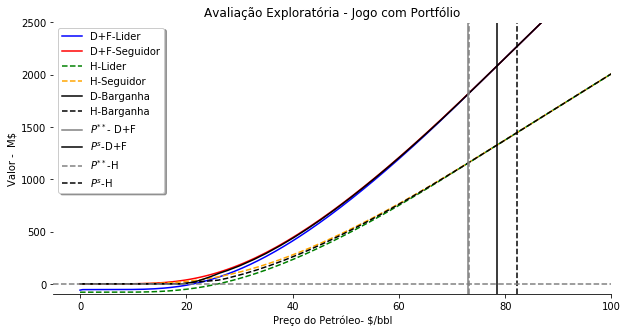

In [372]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)
print('Hoje, o gatilho explorar $\Pi$ Dog+Feather é:',round(gatilho_port,3))
print('Hoje, o gatilho explorar Head é:',round(g[0],3))
print('Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é:',pa1)
print('Hoje, o gatilho simultaneo Head é:',pa)

ax.plot(preco_inv,L_zero1, color='blue', ls='-' )
ax.plot(preco_inv,F_zero1, color='red', ls='-' )

ax.plot(preco_inv,L_zero, color='green', ls='--' )
ax.plot(preco_inv,F_zero, color='orange', ls='--' )

ax.plot(preco_inv,(1-wi)*vme_barganha_max, color='black', ls='-')
ax.plot(preco_inv,wi*vme_barganha_max, color='black', ls='--')

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axvline(x=gatilho_port, linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')


ax.axhline(0, linestyle='--', color='grey')

#ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['D+F-Lider','D+F-Seguidor','H-Lider','H-Seguidor','D-Barganha','H-Barganha','$P^{**}$- D+F','$P^{s}$-D+F','$P^{**}$-H','$P^{s}$-H'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo- $/bbl')
ax.set_ylabel('Valor -  M$')
ax.set_title('Avaliação Exploratória - Jogo com Portfólio')

ax.set_xlim(right=100)
ax.set_ylim(top=2500)
ax.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

Hoje, o gatilho explorar $\Pi$ Dog+Feather é: 73.0
Hoje, o gatilho explorar Head é: 73.125
Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é: 78.5
Hoje, o gatilho simultaneo Head é: 82.25


[]

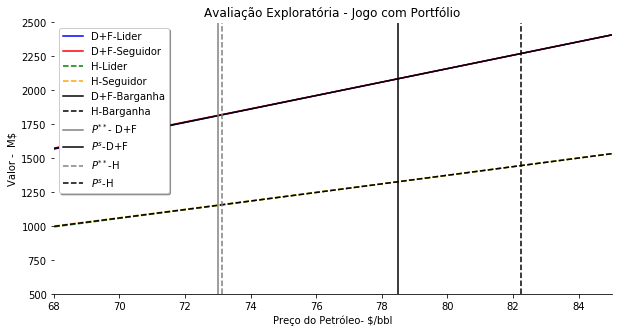

In [385]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)
print('Hoje, o gatilho explorar $\Pi$ Dog+Feather é:',round(gatilho_port,3))
print('Hoje, o gatilho explorar Head é:',round(g[0],3))
print('Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é:',pa1)
print('Hoje, o gatilho simultaneo Head é:',pa)

ax.plot(preco_inv,L_zero1, color='blue', ls='-' )
ax.plot(preco_inv,F_zero1, color='red', ls='-' )

ax.plot(preco_inv,L_zero, color='green', ls='--' )
ax.plot(preco_inv,F_zero, color='orange', ls='--' )

ax.plot(preco_inv,(1-wi)*vme_barganha_max, color='black', ls='-')
ax.plot(preco_inv,wi*vme_barganha_max, color='black', ls='--')

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axvline(x=gatilho_port, linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')


ax.axhline(0, linestyle='--', color='grey')

#ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['D+F-Lider','D+F-Seguidor','H-Lider','H-Seguidor','D+F-Barganha','H-Barganha','$P^{**}$- D+F','$P^{s}$-D+F','$P^{**}$-H','$P^{s}$-H'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo- $/bbl')
ax.set_ylabel('Valor -  M$')
ax.set_title('Avaliação Exploratória - Jogo com Portfólio')
ax.set_xlim(left=68)
ax.set_xlim(right=85)
ax.set_ylim(top=2500)
ax.set_ylim(bottom=500)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [377]:
preco_barganha_plus=np.loadtxt('barganha_plus_tres_ativos_preco.txt')

In [378]:
vme_barganha_plus=np.loadtxt('barganha_plus_tres_ativos_vme.txt')

In [379]:
vme_barganha_plus_interp=np.interp(preco_inv,preco_barganha_plus,vme_barganha_plus)

In [380]:
vme_barganha_plus_max=np.maximum(0,vme_barganha_plus_interp)

In [381]:
####Pedaco do Godfish
wi_plus=.5+( np.maximum(0,L_zero)-np.maximum(0,L_zero1))/(2*vme_barganha_plus_max)

C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [382]:
wi_plus=np.nan_to_num(wi_plus)

[]

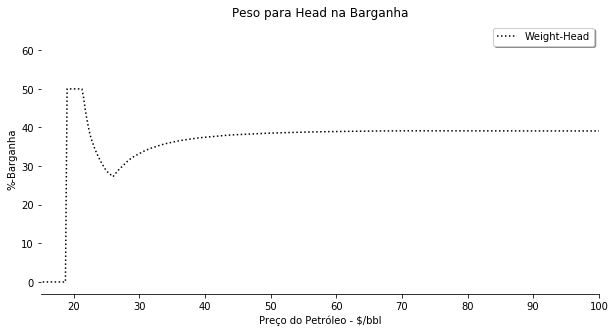

In [383]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

#ax.axvline(pa, linestyle='--', color='grey')
ax.plot(preco_inv,100*wi_plus, ls=':', color='black')
#ax.set_ylim(0,100)
#ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Weight-Head'], shadow=True)
ax.set_xlabel('Preço do Petróleo - $/bbl')
ax.set_ylabel('%-Barganha')
ax.set_xlim(right=100)
ax.set_xlim(left=15)
#ax.set_ylim(top=65)
#ax.set_ylim(bottom=40)
ax.set_title('Peso para Head na Barganha')

plt.plot()

Hoje, o gatilho explorar $\Pi$ Dog+Feather é: 73.0
Hoje, o gatilho explorar Head é: 73.125
Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é: 78.5
Hoje, o gatilho simultaneo Head é: 82.25


[]

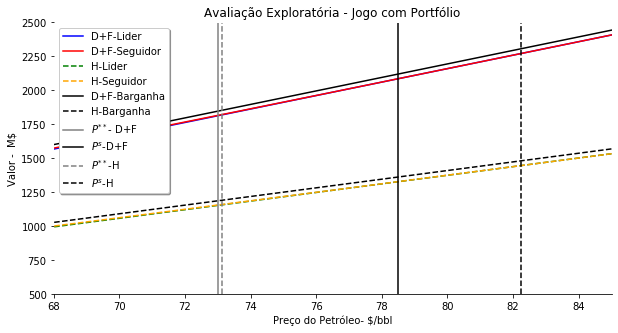

In [386]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)
print('Hoje, o gatilho explorar $\Pi$ Dog+Feather é:',round(gatilho_port,3))
print('Hoje, o gatilho explorar Head é:',round(g[0],3))
print('Hoje, o gatilho simultaneo $\Pi$ Dog+Feather é:',pa1)
print('Hoje, o gatilho simultaneo Head é:',pa)

ax.plot(preco_inv,L_zero1, color='blue', ls='-' )
ax.plot(preco_inv,F_zero1, color='red', ls='-' )

ax.plot(preco_inv,L_zero, color='green', ls='--' )
ax.plot(preco_inv,F_zero, color='orange', ls='--' )

ax.plot(preco_inv,(1-wi_plus)*vme_barganha_plus_max, color='black', ls='-')
ax.plot(preco_inv,wi_plus*vme_barganha_plus_max, color='black', ls='--')

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axvline(x=gatilho_port, linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')


ax.axhline(0, linestyle='--', color='grey')

#ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['D+F-Lider','D+F-Seguidor','H-Lider','H-Seguidor','D+F-Barganha','H-Barganha','$P^{**}$- D+F','$P^{s}$-D+F','$P^{**}$-H','$P^{s}$-H'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo- $/bbl')
ax.set_ylabel('Valor -  M$')
ax.set_title('Avaliação Exploratória - Jogo com Portfólio')
ax.set_xlim(left=68)
ax.set_xlim(right=85)
ax.set_ylim(top=2500)
ax.set_ylim(bottom=500)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()